# CNS Laboratory 3

Author: Luca Moroni

In [139]:
# create the folder in which i will save the stuffs
# images folder
!mkdir Images

# saved object folder
!mkdir Objects

mkdir: cannot create directory ‘Images’: File exists


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.pyplot import figure
import itertools
import random


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function Definitions

In [141]:
def active_reproducibility(manual_seed=42):
    """
      Function that set random seeds for every used library.
    """

    torch.manual_seed(manual_seed)
    random.seed(manual_seed)
    np.random.seed(manual_seed)


def evaluate(model, X_valid, y_valid, loss_fn, **model_args):
    """
      Evaluate trained model over (X_valid, y_valid) dataset throught loss_fn.
    """

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_valid, **model_args)

        if type(y_pred) == tuple:
          y_pred = y_pred[0]

        loss = loss_fn(y_pred.view(-1), y_valid.view(-1))
        
    return loss.item()


def train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train, train_args):
    """
    Train the model given by the model_compile function, compute the running losses
    over the train and valid sets.
    """

    learning_rate = train_args["learning_rate"]
    num_epochs = train_args["num_epochs"]

    model_args = train_args.copy()
    del model_args["learning_rate"]
    del model_args["num_epochs"]


    X_train = X_train.to(DEVICE)
    y_train = y_train.to(DEVICE)
    
    X_valid = X_valid.to(DEVICE)
    y_valid = y_valid.to(DEVICE)

    model = model_compile(model_args).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []
    

    for i in tqdm(range(num_epochs)):
        model.train()

        # one step train
        train_loss, valid_loss = one_step_train(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn)

        train_losses.append(train_loss)
    
        valid_losses.append(valid_loss)
    
    return train_losses, valid_losses, model, optimizer


def grid_search(model_compile, one_step_train_loop, grid, X_train, y_train, X_valid, y_valid):
    """
    Grid search the best parameters of the model, the parameters are get out from
    the grid dictionary, iterating over all the possible combination of the values
    in it.
    """
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for args_comb in itertools.product(*grid.values()):

        train_args = {k:v for (k, v) in zip(list(grid.keys()), args_comb)}
        
        train_losses, valid_losses, _, _ = train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train_loop, train_args)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = train_args
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", train_args, "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", best_params, "with a loss of: ", best_loss)
        
    return best_train_losses, best_valid_losses, best_params


def predict(X, model):
    return model(X.to(DEVICE))

In [142]:
def save_stuffs(model, train_args, optimizer, train_losses, test_losses, PATH):
    """
    Save data into disk at PATH location
    """

    model_args = train_args.copy()
    del model_args["learning_rate"]
    del model_args["num_epochs"]
    
    # save the model, the optimizer, and the model. see https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'train_losses': train_losses,
              'test_losses': test_losses,
              'model_args': model_args,
              }, PATH+"_model_optimizer_losses")
    

def load_stuffs(model_build, PATH):
    """
    Load data from disk at PATH location
    """

    checkpoint = torch.load(PATH+"_model_optimizer_losses")
    model_args = checkpoint['model_args']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    model_dict = checkpoint['model_state_dict']
    optimizer_dict = checkpoint['optimizer_state_dict']

    model = model_build(model_args)
    optimizer = torch.optim.Adam(model.parameters())
    
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

    return model, optimizer, train_losses, test_losses

## Time Delay Neural Network

Here I will define the Time Delay Neural Network model, its compile function and the training step.

In [143]:
class TDNN(nn.Module):
    """
    Time Delay Neural Network model
    """

    def __init__(self, window_size=5, hidden_layers=1, hidden_dim=128, out_dim=1):
        super().__init__()
        
        self.window_size = window_size
        
        layers = [nn.Linear(window_size, hidden_dim), nn.ReLU()]
        
        for i in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        
        self.sequential = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Forwar phase of TDNN, take x perform an unfolding of window_size dimension
        and return the output for each time-step.        
        """

        pad = torch.zeros(self.window_size-1).to(DEVICE)
        input_ = torch.cat([pad, x]).unfold(dimension=0, size=self.window_size, step=1)
        
        return self.sequential(input_)

In [144]:
def model_compile_tdnn(args):
    return TDNN(**args)


def one_step_train_loop_tdnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    """
    one single step of training (one epoch) for a Time Delay Neural Network model
    """

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    valid_loss = evaluate(model, X_valid, y_valid, loss_fn)

    return train_loss, valid_loss

## RNN

Here I will define the Recurrent Neural Network model, its compile function and the training step.

In [145]:
class RNNModel(nn.Module):
    """
    Recurrent Neural Network model
    """

    def __init__(self, input_dim=1, hidden_dim=128, hidden_layers=1, output_dim=1, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.hidden_layers = hidden_layers
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, hidden_layers, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0=None):
        """
        The forward method of the Recurrent Neural Network. The method can eventually
        take the h0 vector in input. If not the h0 will set to zero vector.
        """
        if h0 is None:
          hidden_state = torch.zeros(self.hidden_layers, self.hidden_dim).to(DEVICE)

        if len(x.shape) == 1:
          x = x.reshape((x.shape[0], 1))

        out, hn = self.rnn(x, h0)
        
        out = self.fc(out)
        return out, hn

In [146]:
def model_compile_rnn(args):
    return RNNModel(**args)


def one_step_train_loop_rnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    """
    one single step of training (one epoch) for a Recurrent Neural Network model
    """

    optimizer.zero_grad()
    y_pred, hidden_state = model(X_train)

    loss = loss_fn(y_pred.view(-1), y_train.view(-1))
    loss.backward()
    optimizer.step()
    hidden_state = hidden_state.detach()

    train_loss = loss.item()

    valid_loss = evaluate(model, X_valid, y_valid, loss_fn, **{"h0" : hidden_state})

    return train_loss, valid_loss

# NARMA10

The first Task is concerned to the prediction of NARMA10 dataset.
Here I will load the dataset from the csv file, splitting it into input (X) and output (y) and I will plot the first 200 elements of each of them.

In [147]:
data_narma10 = pd.read_csv("NARMA10.csv", header=None)

In [148]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [149]:
NARMA10_X = torch.Tensor(data_narma10.values[0, :])
NARMA10_y = torch.Tensor(data_narma10.values[1, :])

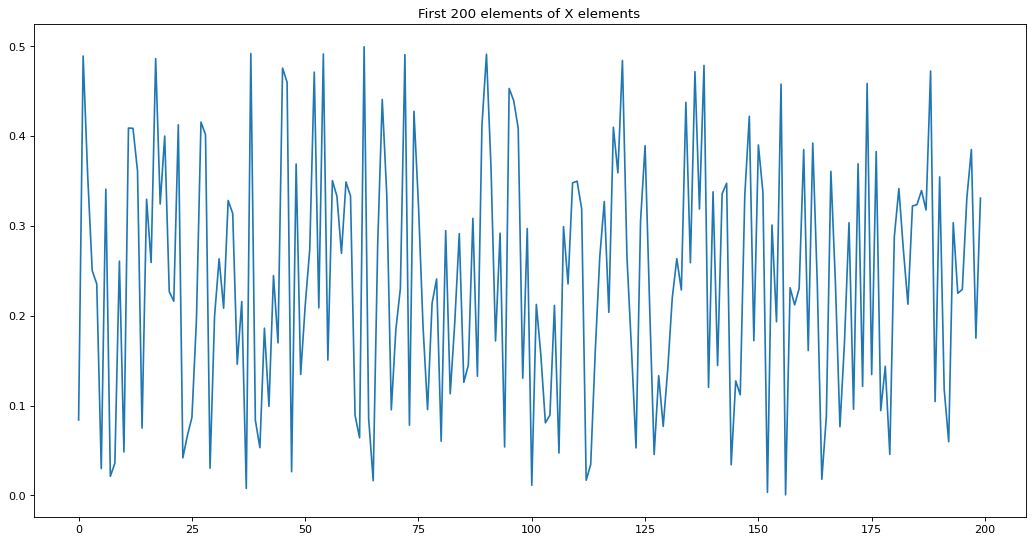

In [150]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(NARMA10_X[:200])
plt.show()

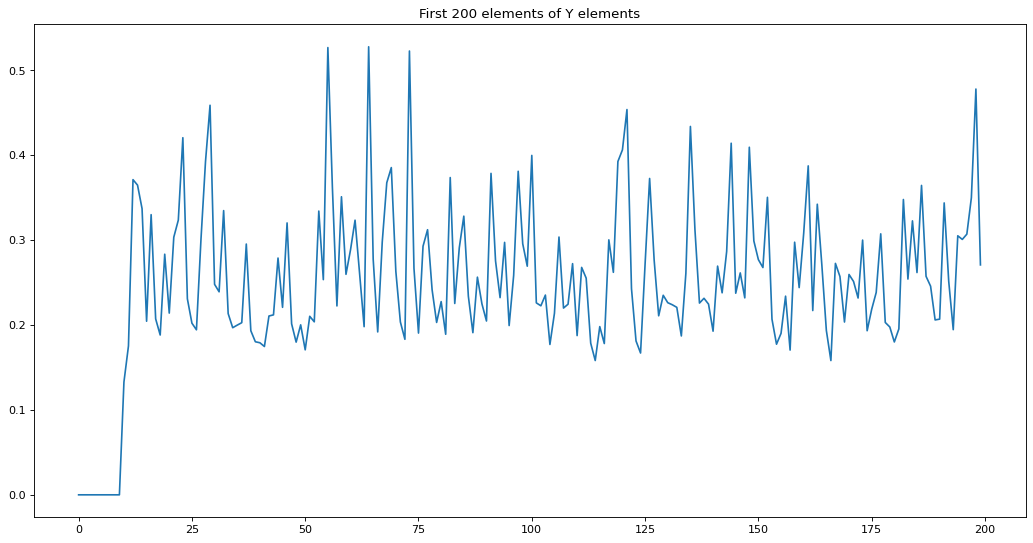

In [151]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(NARMA10_y[:200])
plt.show()

## TDNN

In [152]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

Grid search for Time Delay Neural Network over NARMA10 dataset.
I will search over:
- number of delay's steps (window_size).
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [153]:
grid = {
    "window_size" : [10, 30],
    "hidden_layers" : [1, 2],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-2],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:00<00:00, 590.15it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004687616601586342


100%|██████████| 200/200 [00:00<00:00, 593.40it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004912309814244509


100%|██████████| 200/200 [00:00<00:00, 587.49it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004586833994835615


100%|██████████| 200/200 [00:00<00:00, 569.85it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004884988069534302


100%|██████████| 200/200 [00:00<00:00, 381.64it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004675855860114098


100%|██████████| 200/200 [00:00<00:00, 394.85it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004717141389846802


100%|██████████| 200/200 [00:00<00:00, 360.82it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004738807212561369


100%|██████████| 200/200 [00:00<00:00, 376.92it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004898744635283947


100%|██████████| 200/200 [00:00<00:00, 543.90it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.001576063223183155


100%|██████████| 200/200 [00:00<00:00, 571.64it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0009805784793570638


100%|██████████| 200/200 [00:00<00:00, 572.21it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.001263222424313426


100%|██████████| 200/200 [00:00<00:00, 591.71it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0010319264838472009


100%|██████████| 200/200 [00:00<00:00, 476.34it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00078205595491454


100%|██████████| 200/200 [00:00<00:00, 449.89it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0009482967434450984


100%|██████████| 200/200 [00:00<00:00, 355.88it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.000691111374180764


100%|██████████| 200/200 [00:00<00:00, 468.57it/s]

 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0006014808313921094
finished grid search, the best are: {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} with a loss of:  0.0006014808313921094


In [154]:
NARMA10_TDNN_valid_loss = valid_losses[-1]

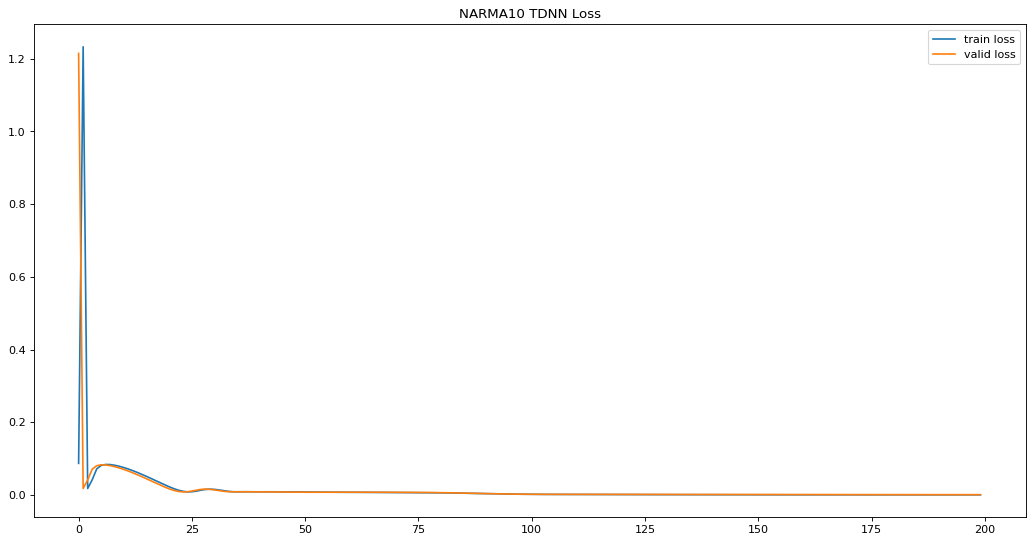

In [155]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.title("NARMA10 TDNN Loss")
plt.show()

In [156]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [157]:
best_params

{'window_size': 30,
 'hidden_layers': 2,
 'hidden_dim': 256,
 'learning_rate': 0.01,
 'num_epochs': 200}

In [158]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 200/200 [00:00<00:00, 434.52it/s]


In [159]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/NARMA10_TDNN")

In [160]:
# load_stuffs(model_compile_tdnn, "NARMA10_TDNN")

In [161]:
NARMA10_TDNN_train_loss = train_losses[-1]
NARMA10_TDNN_test_loss = test_losses[-1]

In [162]:
print("TDNN NARMA10 Losses")
print("-- MSE Train", NARMA10_TDNN_train_loss)
print("-- MSE Valid", NARMA10_TDNN_valid_loss)
print("-- MSE Test", NARMA10_TDNN_test_loss)

TDNN NARMA10 Losses
-- MSE Train 0.00045091265928931534
-- MSE Valid 0.0006014808313921094
-- MSE Test 0.0005069525795988739


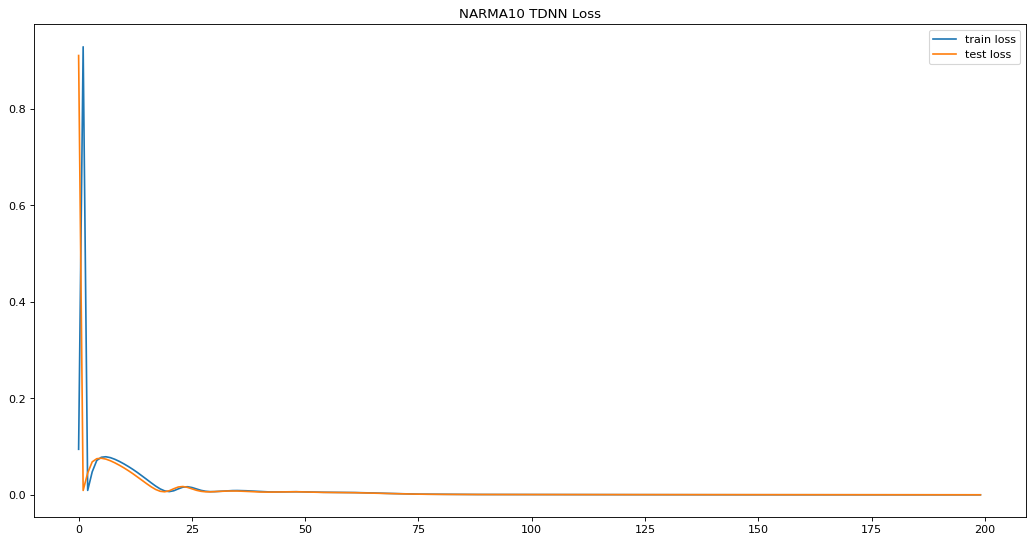

In [163]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("NARMA10 TDNN Loss")
plt.savefig("Images/NARMA10_TDNN_FinalTraining")
plt.show()

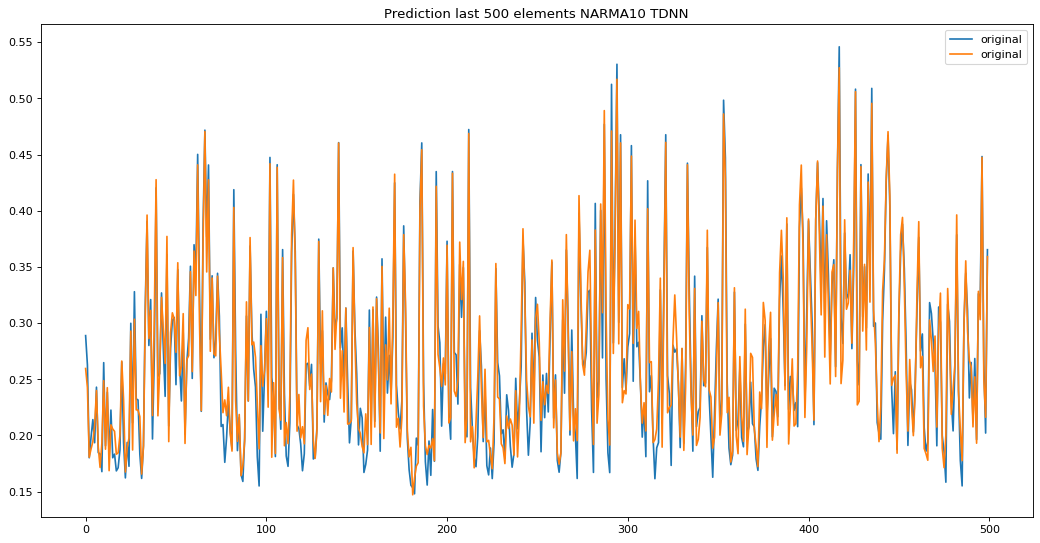

In [164]:
figure(figsize=(16, 8), dpi=80)
y_pred = predict(torch.Tensor(NARMA10_X), model)
plt.title("Prediction last 500 elements NARMA10 TDNN")
plt.plot(NARMA10_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/NARMA10_TDNN_Pred")
plt.show()

## RNN

In [165]:
# train split
X_train = NARMA10_X[:4000]
y_train = NARMA10_y[:4000]

# valid split
X_valid = NARMA10_X[4000:5000]
y_valid = NARMA10_y[4000:5000]

Grid search for Recurrent Neural Network over NARMA10 dataset.
I will search over:
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [166]:
grid = {
    "hidden_layers" : [1, 2, 3],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-4, 1e-5],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:05<00:00, 37.90it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.006166051607578993


100%|██████████| 200/200 [00:06<00:00, 31.27it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.03994332626461983


100%|██████████| 200/200 [00:07<00:00, 26.49it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.005447135306894779


100%|██████████| 200/200 [00:06<00:00, 31.73it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007206462323665619


100%|██████████| 200/200 [00:03<00:00, 59.44it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004259738139808178


100%|██████████| 200/200 [00:04<00:00, 49.11it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.0073293535970151424


100%|██████████| 200/200 [00:11<00:00, 17.17it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.003093368373811245


100%|██████████| 200/200 [00:11<00:00, 17.25it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007036793977022171


100%|██████████| 200/200 [00:04<00:00, 42.68it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004955735523253679


100%|██████████| 200/200 [00:04<00:00, 43.70it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 128, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.00765075720846653


100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


 -- finished {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0024601228069514036


100%|██████████| 200/200 [00:17<00:00, 11.65it/s]

 -- finished {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 1e-05, 'num_epochs': 200} loss 0.007077906746417284
finished grid search, the best are: {'hidden_layers': 3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} with a loss of:  0.0024601228069514036


In [167]:
NARMA10_RNN_valid_loss = valid_losses[-1]

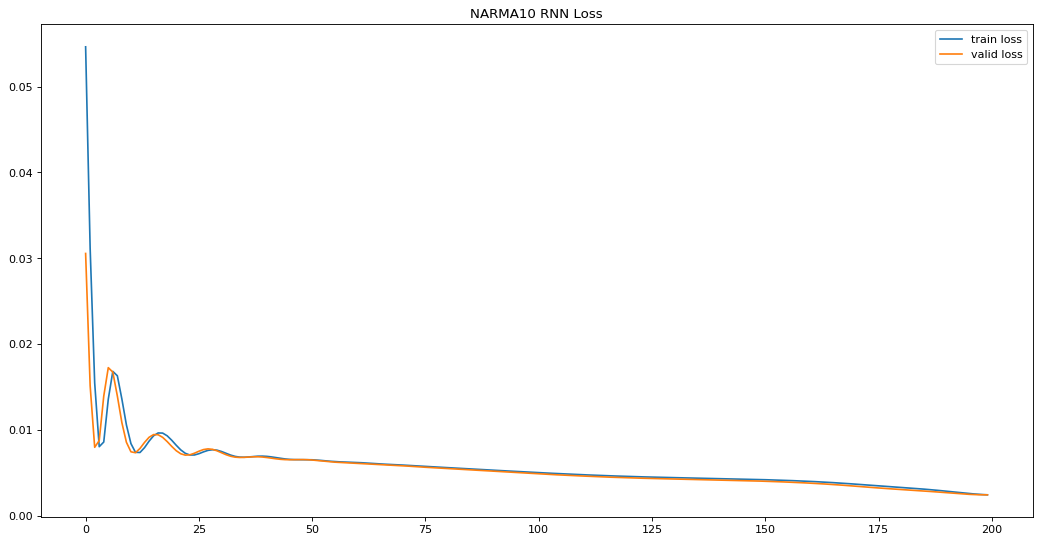

In [168]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.title("NARMA10 RNN Loss")
plt.show()

In [169]:
# test split
X_test = NARMA10_X[5000:]
y_test = NARMA10_y[5000:]

# train split
X_train = NARMA10_X[:5000]
y_train = NARMA10_y[:5000]

In [170]:
best_params

{'hidden_layers': 3,
 'hidden_dim': 256,
 'learning_rate': 0.0001,
 'num_epochs': 200}

In [171]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 200/200 [00:28<00:00,  6.97it/s]


In [172]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/NARMA10_RNN")

In [173]:
NARMA10_RNN_train_loss = train_losses[-1]
NARMA10_RNN_test_loss = test_losses[-1]

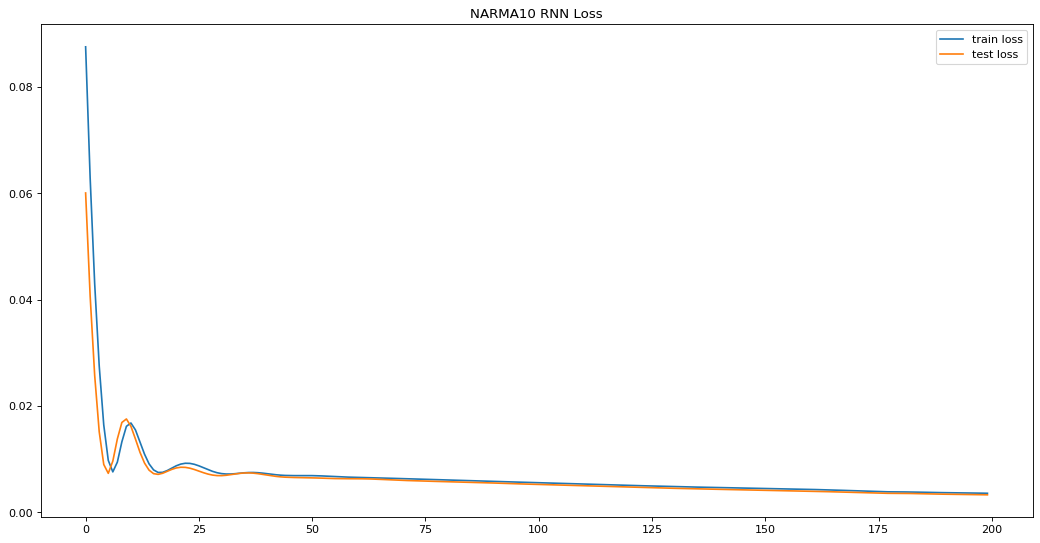

In [174]:
figure(figsize=(16, 8), dpi=80)
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("NARMA10 RNN Loss")
plt.savefig("Images/NARMA10_RNN_FinalTraining")
plt.show()

In [175]:
print("RNN NARMA10 Losses")
print("-- MSE Train", NARMA10_RNN_train_loss)
print("-- MSE Valid", NARMA10_RNN_valid_loss)
print("-- MSE Test", NARMA10_RNN_test_loss)

RNN NARMA10 Losses
-- MSE Train 0.0035787466913461685
-- MSE Valid 0.0024601228069514036
-- MSE Test 0.003289640648290515


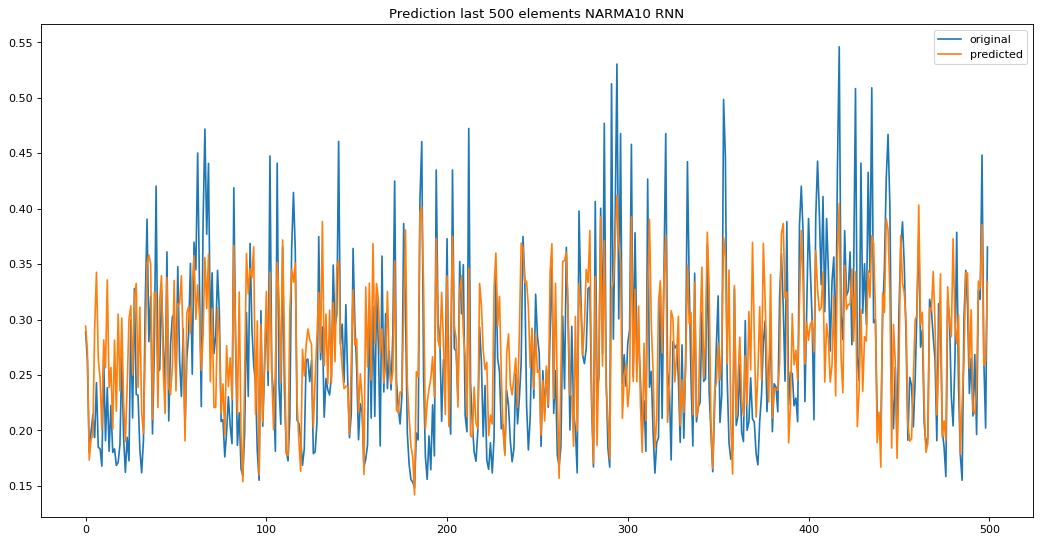

In [176]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = predict(torch.Tensor(NARMA10_X), model)
plt.plot(NARMA10_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.title("Prediction last 500 elements NARMA10 RNN")
plt.savefig("Images/NARMA10_RNN_Pred")
plt.show()

# MG17

In [177]:
data_mg17 = pd.read_csv("MG17.csv", header=None)

In [178]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [179]:
data = data_mg17.values[0, :]

MG17_X = torch.Tensor(data[:-1])
MG17_y = torch.Tensor(data[1:])

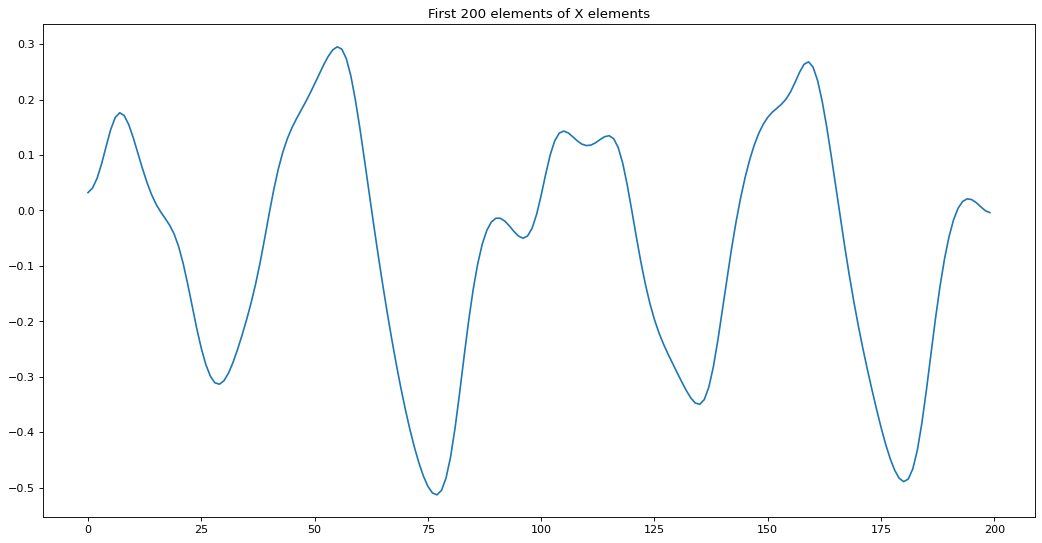

In [180]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of X elements")
plt.plot(MG17_X[:200])
plt.show()

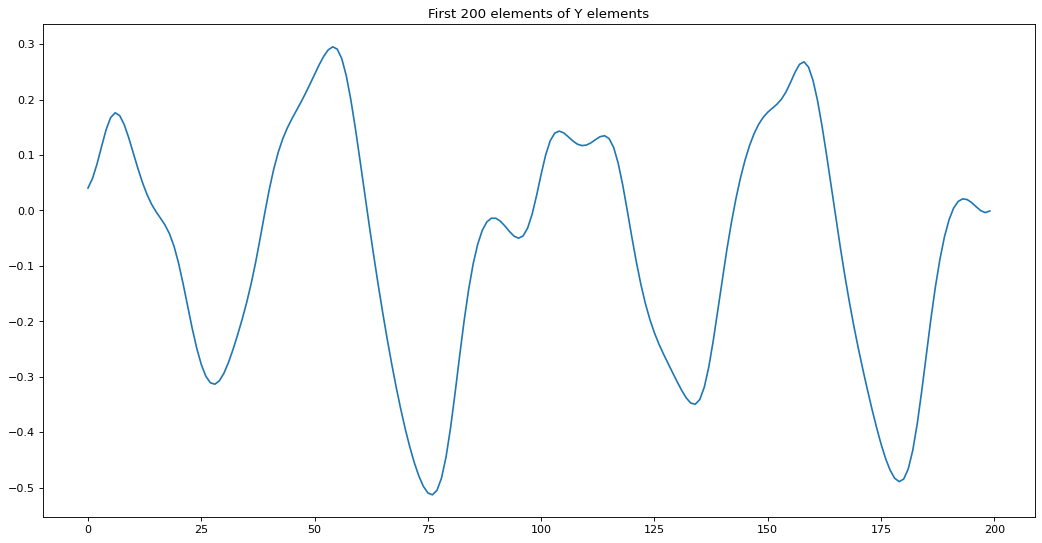

In [181]:
figure(figsize=(16, 8), dpi=80)
plt.title("First 200 elements of Y elements")
plt.plot(MG17_y[:200])
plt.show()

## TDNN

In [182]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

Grid search for Time Delay Neural Network over NARMA10 dataset.
I will search over:
- number of delay's steps (window_size).
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [183]:
grid = {
    "window_size" : [10, 30],
    "hidden_layers" : [1, 2],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-2],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:00<00:00, 581.83it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0008988245972432196


100%|██████████| 200/200 [00:00<00:00, 591.50it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00014565643505193293


100%|██████████| 200/200 [00:00<00:00, 542.64it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0006061045569367707


100%|██████████| 200/200 [00:00<00:00, 602.91it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00015060028817970306


100%|██████████| 200/200 [00:00<00:00, 492.78it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00029120672843419015


100%|██████████| 200/200 [00:00<00:00, 483.67it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00018980736786033958


100%|██████████| 200/200 [00:00<00:00, 449.35it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0001231218921020627


100%|██████████| 200/200 [00:00<00:00, 482.08it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00012192179565317929


100%|██████████| 200/200 [00:00<00:00, 551.64it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0003687057178467512


100%|██████████| 200/200 [00:00<00:00, 562.90it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00030027577304281294


100%|██████████| 200/200 [00:00<00:00, 542.75it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0002797538472805172


100%|██████████| 200/200 [00:00<00:00, 548.67it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0002791125443764031


100%|██████████| 200/200 [00:00<00:00, 469.73it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00033821610850282013


100%|██████████| 200/200 [00:00<00:00, 443.69it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0003388554905541241


100%|██████████| 200/200 [00:00<00:00, 452.38it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.00029747633379884064


100%|██████████| 200/200 [00:00<00:00, 456.47it/s]

 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00034680342650972307
finished grid search, the best are: {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} with a loss of:  0.00012192179565317929


In [184]:
MG17_TDNN_valid_loss = valid_losses[-1]

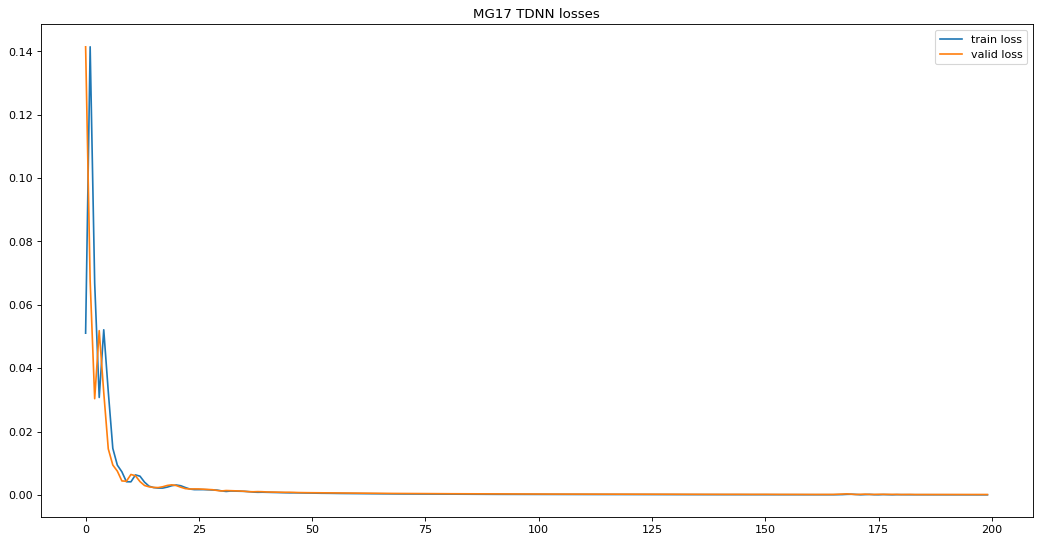

In [185]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 TDNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

In [186]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [187]:
best_params

{'window_size': 10,
 'hidden_layers': 2,
 'hidden_dim': 256,
 'learning_rate': 0.01,
 'num_epochs': 200}

In [188]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 200/200 [00:00<00:00, 446.74it/s]


In [189]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/MG17_TDNN")

In [190]:
MG17_TDNN_train_loss = train_losses[-1]
MG17_TDNN_test_loss = test_losses[-1]

In [191]:
print("TDNN MG17 Losses")
print("-- MSE Train", MG17_TDNN_train_loss)
print("-- MSE Valid", MG17_TDNN_valid_loss)
print("-- MSE Test", MG17_TDNN_test_loss)

TDNN MG17 Losses
-- MSE Train 1.954822801053524e-05
-- MSE Valid 0.00012192179565317929
-- MSE Test 2.3962340492289513e-05


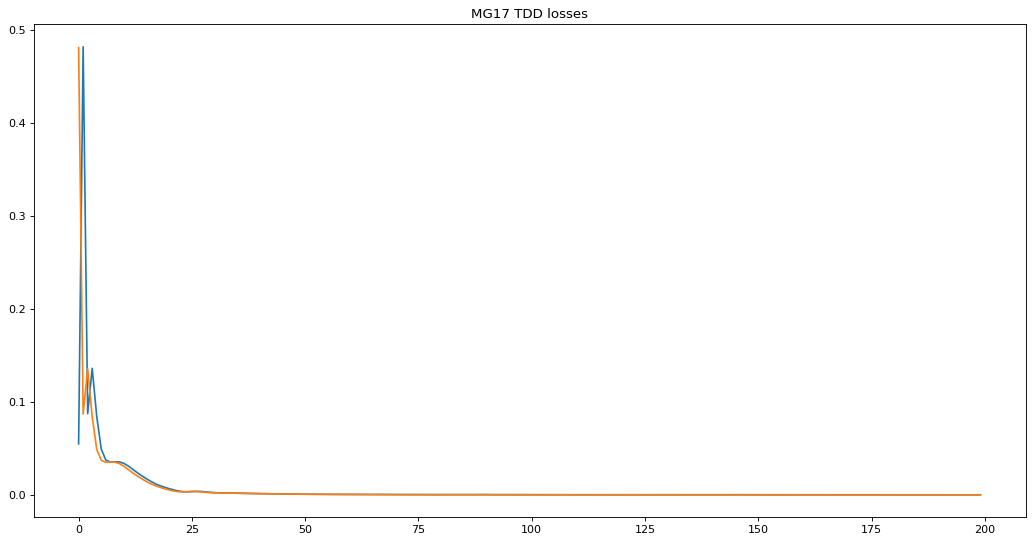

In [192]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 TDNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.savefig("Images/MG17_TDNN_FinalTraining")
plt.show()

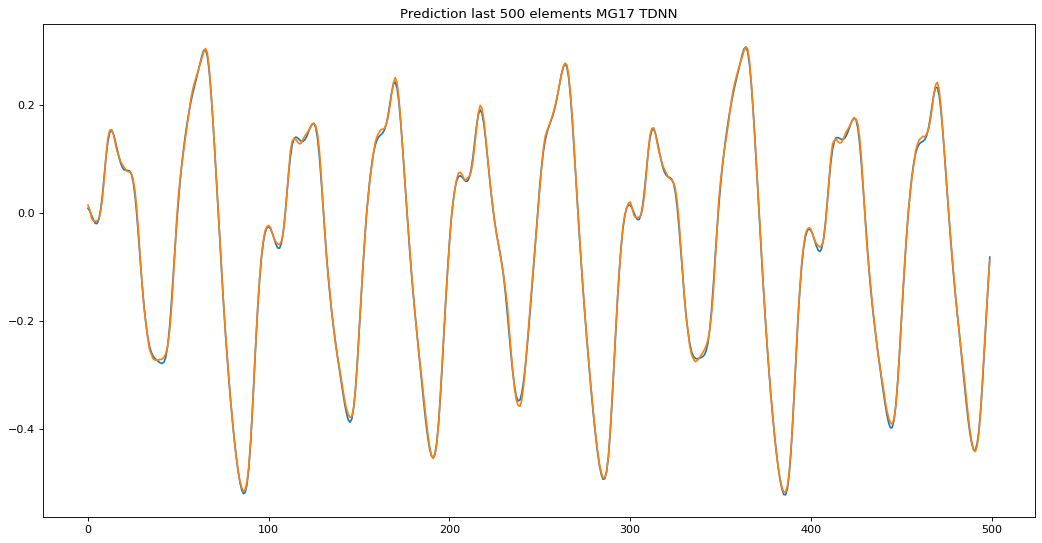

In [193]:
figure(figsize=(16, 8), dpi=80)
y_pred = predict(torch.Tensor(MG17_X), model)
plt.plot(MG17_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predict")
plt.title("Prediction last 500 elements MG17 TDNN")
plt.legend()
plt.savefig("Images/MG17_TDNN_Pred")
plt.show()

## RNN

In [194]:
# train split
X_train = MG17_X[:4000]
y_train = MG17_y[:4000]

# valid split
X_valid = MG17_X[4000:5000]
y_valid = MG17_y[4000:5000]

Grid search for Recurrent Neural Network over MG17 dataset.
I will search over:
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [195]:
grid = {
    "hidden_layers" : [1, 2, 4],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-4],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:02<00:00, 67.67it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0001923756644828245


100%|██████████| 200/200 [00:03<00:00, 64.17it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004812985192984343


100%|██████████| 200/200 [00:06<00:00, 32.29it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0001408847456332296


100%|██████████| 200/200 [00:06<00:00, 30.82it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0009008845663629472


100%|██████████| 200/200 [00:03<00:00, 59.87it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 9.534493437968194e-05


100%|██████████| 200/200 [00:03<00:00, 60.49it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0010576386703178287


100%|██████████| 200/200 [00:11<00:00, 17.09it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 6.661721272394061e-05


100%|██████████| 200/200 [00:11<00:00, 17.17it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.000640870479401201


100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 6.528363155666739e-05


100%|██████████| 200/200 [00:05<00:00, 34.49it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0006450195796787739


100%|██████████| 200/200 [00:22<00:00,  8.90it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 4.4535830966196954e-05


100%|██████████| 200/200 [00:22<00:00,  8.90it/s]

 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.00023668889480177313
finished grid search, the best are: {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} with a loss of:  4.4535830966196954e-05


In [196]:
MG17_RNN_valid_loss = valid_losses[-1]

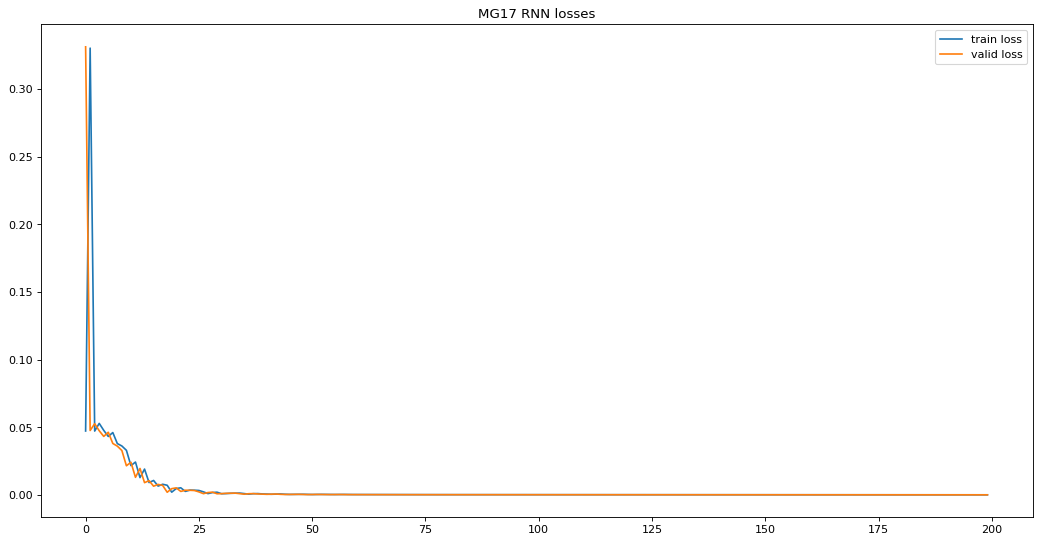

In [197]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 RNN losses")
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

In [198]:
# test split
X_test = MG17_X[5000:]
y_test = MG17_y[5000:]

# train split
X_train = MG17_X[:5000]
y_train = MG17_y[:5000]

In [199]:
train_losses, test_losses, model, optimizer = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


In [200]:
# Save model, optimizer and losses into the disk
save_stuffs(model, best_params, optimizer, train_losses, test_losses, "Objects/MG17_RNN")

In [201]:
MG17_RNN_train_loss = train_losses[-1]
MG17_RNN_test_loss = test_losses[-1]

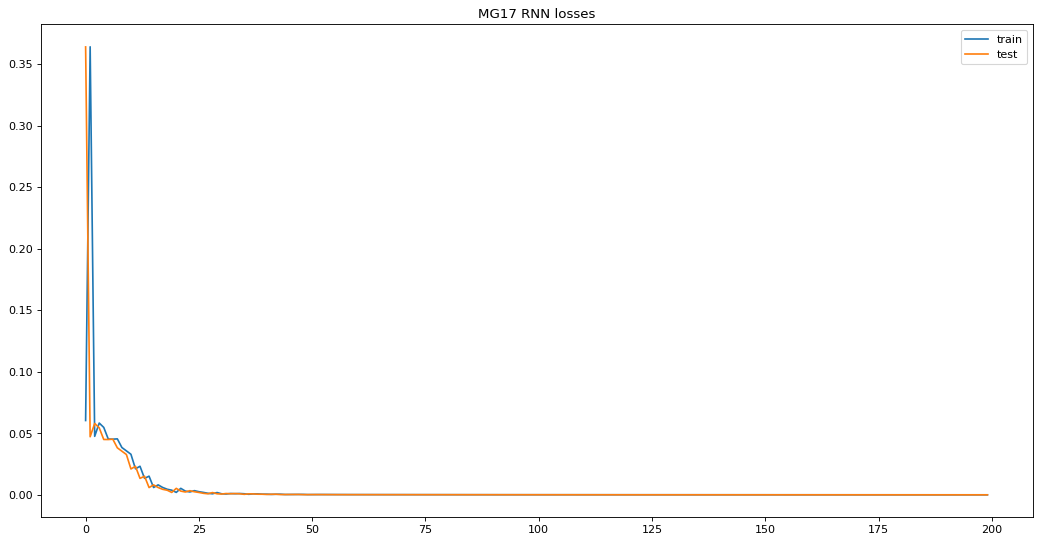

<Figure size 640x480 with 0 Axes>

In [202]:
figure(figsize=(16, 8), dpi=80)
plt.title("MG17 RNN losses")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()
plt.savefig("Images/MG17_RNN_FinalTraining")

In [203]:
print("TDNN MG17 Losses")
print("-- MSE Train", MG17_RNN_train_loss)
print("-- MSE Valid", MG17_RNN_valid_loss)
print("-- MSE Test", MG17_RNN_test_loss)

TDNN MG17 Losses
-- MSE Train 4.762932439916767e-05
-- MSE Valid 4.4535830966196954e-05
-- MSE Test 4.547757998807356e-05


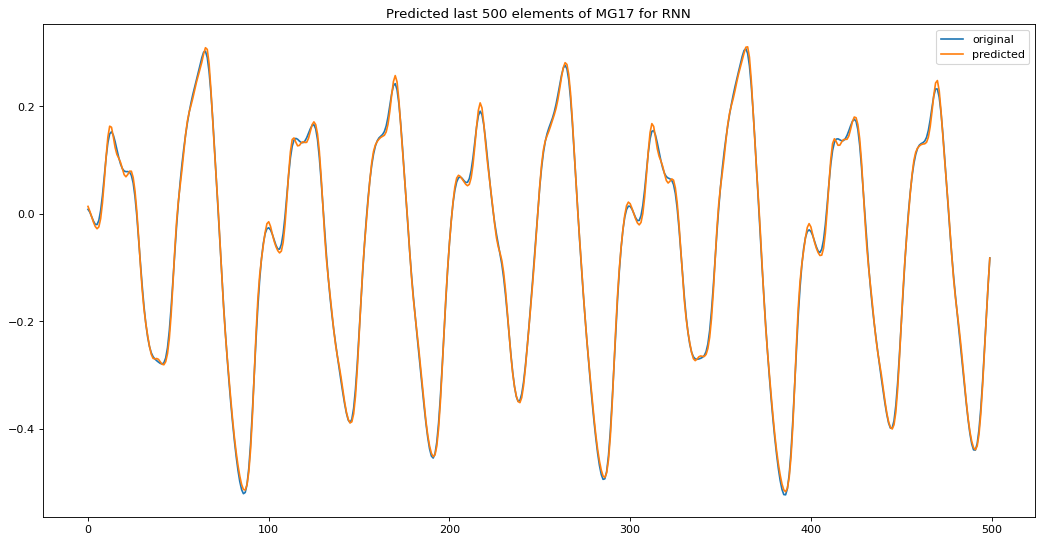

In [204]:
figure(figsize=(16, 8), dpi=80)
y_pred, _ = predict(torch.Tensor(MG17_X), model)
plt.title("Predicted last 500 elements of MG17 for RNN")
plt.plot(MG17_y[-500:], label="original")
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"), label="predicted")
plt.legend()
plt.savefig("Images/MG17_RNN_Pred")
plt.show()

In [206]:
# zip the folders and download the data

!zip -r Images.zip Images/ 
!zip -r Objects.zip Objects/ 

  adding: Images/ (stored 0%)
  adding: Images/MG17_TDNN_FinalTraining.png (deflated 20%)
  adding: Images/NARMA10_TDNN_FinalTraining.png (deflated 20%)
  adding: Images/MG17_RNN_FinalTraining.png (deflated 90%)
  adding: Images/NARMA10_RNN_FinalTraining.png (deflated 17%)
  adding: Images/NARMA10_TDNN_Pred.png (deflated 4%)
  adding: Images/NARMA10_RNN_Pred.png (deflated 3%)
  adding: Images/MG17_RNN_Pred.png (deflated 4%)
  adding: Images/MG17_TDNN_Pred.png (deflated 4%)
  adding: Objects/ (stored 0%)
  adding: Objects/NARMA10_RNN_model_optimizer_losses (deflated 8%)
  adding: Objects/MG17_TDNN_model_optimizer_losses (deflated 24%)
  adding: Objects/NARMA10_TDNN_model_optimizer_losses (deflated 12%)
  adding: Objects/MG17_RNN_model_optimizer_losses (deflated 8%)
